In [2]:
from google.colab import drive
from google.colab import files
drive.mount('/content/drive')

import matplotlib.pyplot as plt

import os
import pandas as pd

import numpy as np
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.autograd import Variable
import torch.utils.data as data
from torch.utils.data import Dataset
from torch.utils.data import DataLoader
import torch.optim as optim

import torchvision
from torchvision.models import resnet50, ResNet50_Weights
from torchvision.io import read_image
import torchvision.transforms as transforms

from tqdm import tqdm

import time

import PIL

Mounted at /content/drive


In [3]:
!pip install torchinfo

In [4]:
import torchinfo

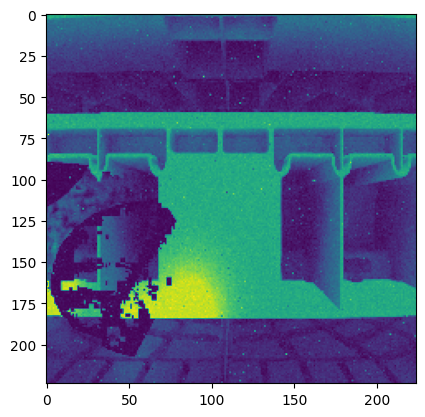

In [5]:
class CustomRGBImageDataset(Dataset):
    def __init__(self, annotations_file, img_dir, transform=None, target_transform=None):
        self.img_labels = pd.read_csv(annotations_file)[0:9000]
        self.img_dir = img_dir
        self.transform = transform
        self.target_transform = target_transform

    def __len__(self):
        return len(self.img_labels)

    def __getitem__(self, idx):
        img_path = os.path.join(self.img_dir, self.img_labels.iloc[idx, 0])
        image = read_image(img_path)
        label = torch.tensor(self.img_labels.iloc[idx, 1:7])
        if self.transform:
            image = self.transform(image)
        if self.target_transform:
            label = self.target_transform(label)
        return image, label


class CustomDepthImageDataset(Dataset):
    def __init__(self, annotations_file, img_dir, transform=None, target_transform=None):
        self.img_labels = pd.read_csv(annotations_file)[0:9000]
        for index, img_label in enumerate(self.img_labels.iloc[:,0]):
            depth_img_label = img_label.replace("rgb_image_", "depth_image_").replace("png", "npy")
            self.img_labels.iloc[index,0] = depth_img_label

        self.img_dir = img_dir
        self.transform = transform
        self.target_transform = target_transform

    def __len__(self):
        return len(self.img_labels)

    def __getitem__(self, idx):
        img_path = os.path.join(self.img_dir, self.img_labels.iloc[idx, 0])
        np_img = np.load(img_path)
        np_img[np_img > 1] = 0
        np_img[np.isnan(np_img)] = 0
        image = torch.tensor(np_img).unsqueeze(0)
        image = image.expand(3, *image.shape[1:])
        label = torch.tensor(self.img_labels.iloc[idx, 1:7])
        if self.transform:
            image = self.transform(image)
        if self.target_transform:
            label = self.target_transform(label)
        return image, label






depth_transform  = torchvision.transforms.Compose([
    torchvision.transforms.Grayscale(num_output_channels=3),
    torchvision.transforms.Resize((224,224)),
    #torchvision.transforms.ToTensor(),
])


rgb_transform = torchvision.transforms.Compose([
    torchvision.transforms.Resize((224,224)),
    torchvision.transforms.Normalize((0.5, 0.5, 0.5), (0.25, 0.25, 0.25)),

])

#print(os.path.exists("drive/MyDrive/Colab Notebooks/dataset_20k/dataset/labels.csv"))

path_to_labels = "drive/MyDrive/Colab Notebooks/dataset_nd_rgb_resize-10k/dataset/labels.csv"
path_to_rgb_imgs = "drive/MyDrive/Colab Notebooks/dataset_nd_rgb_resize-10k/dataset/rgb/"
path_to_depth_imgs = "drive/MyDrive/Colab Notebooks/dataset_nd_rgb_resize-10k/dataset/depth/"


dataset_rgb = CustomRGBImageDataset(path_to_labels, path_to_rgb_imgs)
dataset_depth = CustomDepthImageDataset(path_to_labels, path_to_depth_imgs, transform = depth_transform)


#generator1 = torch.Generator().manual_seed(42)

#[rgb_training_data, rgb_test_data] = torch.utils.data.random_split(dataset_rgb, [0.9, 0.1], generator1)
#[depth_training_data, depth_test_data] = torch.utils.data.random_split(dataset_depth, [0.9, 0.1], generator1)



batch_size = 32



rgb_train_dataloader = DataLoader(dataset_rgb, batch_size=batch_size ,shuffle=False, num_workers=2,pin_memory=True,prefetch_factor=30)
#rgb_test_dataloader = DataLoader(rgb_test_data, batch_size=batch_size ,shuffle=False, num_workers=2,pin_memory=True,prefetch_factor=30)

depth_train_dataloader = DataLoader(dataset_depth, batch_size=batch_size ,shuffle=False, num_workers=2,pin_memory=True,prefetch_factor=30)
#depth_test_dataloader = DataLoader(depth_test_data, batch_size=batch_size ,shuffle=False, num_workers=2,pin_memory=True,prefetch_factor=30)


plt.imshow(dataset_rgb.__getitem__(3999)[0][2])

tensor(0.9992, dtype=torch.float64)


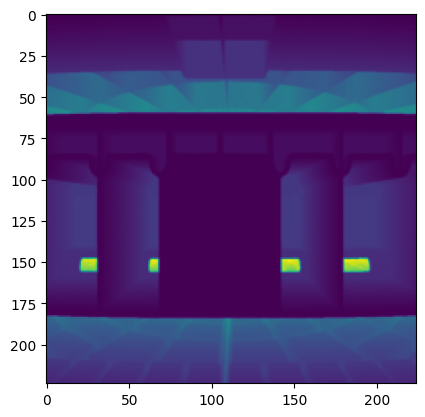

In [6]:
plt.imshow(dataset_depth.__getitem__(3999)[0][2])

print(torch.max(dataset_depth.__getitem__(4)[0]))

#plt.imshow(rgb_training_data.__getitem__(0)[0][0])
#plt.show()

In [7]:
rgb_cnn = resnet50(weights=ResNet50_Weights.DEFAULT)
depth_cnn = resnet50(weights=ResNet50_Weights.DEFAULT)



depth_cnn

Downloading: "https://download.pytorch.org/models/resnet50-11ad3fa6.pth" to /root/.cache/torch/hub/checkpoints/resnet50-11ad3fa6.pth
100%|██████████| 97.8M/97.8M [00:00<00:00, 117MB/s]


ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): Bottleneck(
      (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn3): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (downsample): Sequential(
        (0): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 

In [9]:
# depth_cnn.conv1 = nn.Conv2d(1, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=True)

rgb_cnn = resnet50(weights=ResNet50_Weights.DEFAULT)
depth_cnn = resnet50(weights=ResNet50_Weights.DEFAULT)



depth_cnn.layer4 = nn.Sequential(
    nn.Conv2d(1024, 512, kernel_size=(1, 1), stride=(1, 1), bias=True),
    nn.BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True),
    nn.Conv2d(512, 512, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), bias=True),
    nn.BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True),
    nn.Conv2d(512, 2056, kernel_size=(1, 1), stride=(1, 1), bias=True),
    nn.ReLU(inplace=True)
)

rgb_cnn.layer4 = nn.Sequential(
    nn.Conv2d(1024, 512, kernel_size=(1, 1), stride=(1, 1), bias=True),
    nn.BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True),
    nn.Conv2d(512, 512, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), bias=True),
    nn.BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True),
    nn.Conv2d(512, 2056, kernel_size=(1, 1), stride=(1, 1), bias=True),
    nn.ReLU(inplace=True)
)

depth_cnn.fc = nn.Sequential(
    #nn.Dropout(p=0.1),
    nn.LazyLinear(256,bias=True),
    nn.Tanh(),
)

rgb_cnn.fc = nn.Sequential(
    #nn.Dropout(p=0.1),
    nn.LazyLinear(256,bias=True),
    nn.Tanh(),
)

final_pose_estimator = nn.Sequential(
    #nn.Dropout(p=0.0),
    nn.Linear(512, 16, bias=True),
    nn.Linear(16, 6, bias=True)


)


depth_cnn.to('cuda')
rgb_cnn.to('cuda')
final_pose_estimator.to('cuda')

def paralle_cnn(rgb, depth):
    rgb_out = rgb_cnn(rgb)
    depth_out = rgb_cnn(depth)
    cat_out = torch.cat([rgb_out, depth_out], dim=1)
    return final_pose_estimator(cat_out)

depth_cnn


ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): Bottleneck(
      (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn3): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (downsample): Sequential(
        (0): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 

In [ ]:
torchinfo.summary( rgb_cnn)

Layer (type:depth-idx)                   Param #
ResNet                                   --
├─Conv2d: 1-1                            9,408
├─BatchNorm2d: 1-2                       128
├─ReLU: 1-3                              --
├─MaxPool2d: 1-4                         --
├─Sequential: 1-5                        --
│    └─Bottleneck: 2-1                   --
│    │    └─Conv2d: 3-1                  4,096
│    │    └─BatchNorm2d: 3-2             128
│    │    └─Conv2d: 3-3                  36,864
│    │    └─BatchNorm2d: 3-4             128
│    │    └─Conv2d: 3-5                  16,384
│    │    └─BatchNorm2d: 3-6             512
│    │    └─ReLU: 3-7                    --
│    │    └─Sequential: 3-8              16,896
│    └─Bottleneck: 2-2                   --
│    │    └─Conv2d: 3-9                  16,384
│    │    └─BatchNorm2d: 3-10            128
│    │    └─Conv2d: 3-11                 36,864
│    │    └─BatchNorm2d: 3-12            128
│    │    └─Conv2d: 3-13               

In [ ]:
torchinfo.summary(final_pose_estimator)

Layer (type:depth-idx)                   Param #
Sequential                               --
├─Dropout: 1-1                           --
├─Linear: 1-2                            8,208
├─Linear: 1-3                            102
Total params: 8,310
Trainable params: 8,310
Non-trainable params: 0

In [10]:
depth_cnn.load_state_dict(torch.load("dual_resnet50posev7_depth_30ep.pth"))
rgb_cnn.load_state_dict(torch.load("dual_resnet50posev7_rgb_30ep.pth"))
final_pose_estimator.load_state_dict(torch.load("dual_final_pose_estimatorv7_30ep.pth"))

depth_cnn.train()
rgb_cnn.train()
final_pose_estimator.train()

Sequential(
  (0): Linear(in_features=512, out_features=16, bias=True)
  (1): Linear(in_features=16, out_features=6, bias=True)
)

In [11]:
lossFunc = nn.MSELoss()
optimizer = optim.Adam(list(depth_cnn.parameters()) + list(rgb_cnn.parameters()) + list(final_pose_estimator.parameters()), lr=0.0000001)



In [ ]:
# ensure training mode
depth_cnn.train()
rgb_cnn.train()
final_pose_estimator.train()


for epoch in range(5):
    inner_loop_counter = 0
    for [rgb_inputs, labels], [depth_inputs, labels_2] in zip(rgb_train_dataloader, depth_train_dataloader):
        print([torch.isnan(rgb_inputs).any(), torch.isnan(depth_inputs).any()])

        if not torch.isnan(depth_inputs).any().item():
            acc = None
            # forward, backward, and then weight update
            y_pred = paralle_cnn(rgb_inputs.float().cuda(), depth_inputs.float().cuda())
            #y_pred = paralle_cnn(rgb_inputs.float(), depth_inputs.float())
            #print(f"raw output {y_pred}")
            loss = lossFunc(y_pred, labels.float().cuda())
            #loss = lossFunc(y_pred, labels.float())

            print(f" test labels {torch.sum(labels - labels_2)}")
            print(loss.item())
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()
            print(f"training loop complete inner loop {inner_loop_counter}")
            inner_loop_counter += 1
        else:
            print('loop skiped due to bad input')
        #test_pred = model((test_input.float()).type(torch.cuda.FloatTensor))
        #acc += torch.mean(torch.abs(y_pred - labels.type(torch.cuda.FloatTensor)),dim = 0)
        #print(f"acc {acc}")
    print(f"epoch {epoch}")

/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()


[tensor(False), tensor(False)]
 test labels 0.0
9.615427188691683e-06
training loop complete inner loop 0
[tensor(False), tensor(False)]
 test labels 0.0
9.729158591653686e-06
training loop complete inner loop 1
[tensor(False), tensor(False)]
 test labels 0.0
9.882806807581801e-06
training loop complete inner loop 2
[tensor(False), tensor(False)]
 test labels 0.0
8.77804632182233e-06
training loop complete inner loop 3
[tensor(False), tensor(False)]
 test labels 0.0
1.2890358448203187e-05
training loop complete inner loop 4
[tensor(False), tensor(False)]
 test labels 0.0
1.0776850103866309e-05
training loop complete inner loop 5
[tensor(False), tensor(False)]
 test labels 0.0
1.570599852129817e-05
training loop complete inner loop 6
[tensor(False), tensor(False)]
 test labels 0.0
7.959274626045953e-06
training loop complete inner loop 7
[tensor(False), tensor(False)]
 test labels 0.0
1.0558806934568565e-05
training loop complete inner loop 8
[tensor(False), tensor(False)]
 test labels 

# New Section

In [103]:
torch.save(rgb_cnn.state_dict(), "dual_resnet50posev7_rgb_30ep.pth")
torch.save(depth_cnn.state_dict(), "dual_resnet50posev7_depth_30ep.pth")
torch.save(final_pose_estimator.state_dict(), "dual_final_pose_estimatorv7_30ep.pth")

In [104]:
from google.colab import files

files.download("dual_resnet50posev7_rgb_30ep.pth")
files.download("dual_resnet50posev7_depth_30ep.pth")
files.download("dual_final_pose_estimatorv7_30ep.pth")


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

In [6]:
class CustomRGBImageTestDataset(Dataset):
    def __init__(self, annotations_file, img_dir, transform=None, target_transform=None):
        self.img_labels = pd.read_csv(annotations_file)[9000:-1]
        self.img_dir = img_dir
        self.transform = transform
        self.target_transform = target_transform

    def __len__(self):
        return len(self.img_labels)

    def __getitem__(self, idx):
        img_path = os.path.join(self.img_dir, self.img_labels.iloc[idx, 0])
        image = read_image(img_path).float()
        label = torch.tensor(self.img_labels.iloc[idx, 1:7])
        if self.transform:
            image = self.transform(image)
        if self.target_transform:
            label = self.target_transform(label)
        return image, label


class CustomDepthImageTestDataset(Dataset):
    def __init__(self, annotations_file, img_dir, transform=None, target_transform=None):
        self.img_labels = pd.read_csv(annotations_file)[9000:-1]
        for index, img_label in enumerate(self.img_labels.iloc[:,0]):
            depth_img_label = img_label.replace("rgb_image_", "depth_image_").replace("png", "npy")
            self.img_labels.iloc[index,0] = depth_img_label

        self.img_dir = img_dir
        self.transform = transform
        self.target_transform = target_transform

    def __len__(self):
        return len(self.img_labels)

    def __getitem__(self, idx):
        img_path = os.path.join(self.img_dir, self.img_labels.iloc[idx, 0])
        np_img = np.load(img_path)
        np_img[np_img > 1] = 0
        image = torch.tensor(np_img).unsqueeze(0)
        image = image.expand(3, *image.shape[1:])
        label = torch.tensor(self.img_labels.iloc[idx, 1:7])
        if self.transform:
            image = self.transform(image)
        if self.target_transform:
            label = self.target_transform(label)
        return image, label


test_dataset_rgb = CustomRGBImageTestDataset(path_to_labels, path_to_rgb_imgs, transform= rgb_transform)
test_dataset_depth = CustomDepthImageTestDataset(path_to_labels, path_to_depth_imgs, transform = depth_transform)

rgb_test_dataloader = DataLoader(test_dataset_rgb, batch_size=1 ,shuffle=False, num_workers=2,pin_memory=True,prefetch_factor=30)


depth_test_dataloader = DataLoader(test_dataset_depth, batch_size=1 ,shuffle=False, num_workers=2,pin_memory=True,prefetch_factor=30)




In [109]:
from typing_extensions import final
acc = 0
count = 0

results = []

#depth_cnn.load_state_dict(torch.load("dual_resnet50posev6_depth_40ep.pth"))
#rgb_cnn.load_state_dict(torch.load("dual_resnet50posev6_rgb_40ep.pth"))
#final_pose_estimator.load_state_dict(torch.load("dual_final_pose_estimatorv6_40ep.pth"))

depth_cnn.eval()
rgb_cnn.eval()
final_pose_estimator.eval()

for [rgb_inputs, labels], [depth_inputs, labels_2] in tqdm(zip(rgb_test_dataloader, depth_test_dataloader)):
    with torch.no_grad():  # Ensure no gradients are calculated
        if not torch.isnan(depth_inputs).any().item():
            y_pred = paralle_cnn(rgb_inputs.float().cuda(), depth_inputs.float().cuda())
            buffer = np.zeros(12)
            buffer[0:6] = np.array(labels)
            buffer[6:12] = np.array(y_pred.cpu())
            results.append(buffer)
            #print(torch.cat((y_pred, labels.type(torch.cuda.FloatTensor)), dim = 1 ) * 1000)

            #acc += torch.mean(torch.abs((y_pred - labels.type(torch.cuda.FloatTensor))), dim = 0)
            #count += 1
            #print(labels.size())
            #print(count)
            #print(f"test {acc / count}")
        else:
            print('loop skiped due to bad input')

results = np.array(results)

# Calculate final accuracy after all iterations
#final_acc = acc / count

/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
157it [00:05, 25.23it/s]

loop skiped due to bad input


999it [00:31, 31.40it/s]


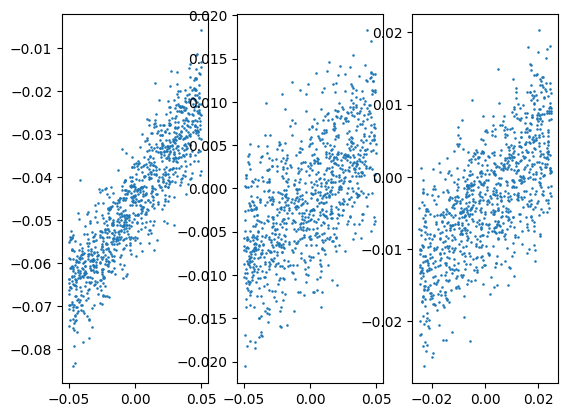

In [110]:
import matplotlib.pyplot as plt

fig, axs = plt.subplots(1,3)

for n, ax in enumerate(axs):
    ax.scatter(results[:,n], results[:,n+6], s= 0.7)

plt.show()

In [111]:
results[0]

array([-0.00845   , -0.03218   , -0.0204    ,  0.        ,  0.        ,
        0.        , -0.04112461, -0.00155245, -0.01650289,  0.014957  ,
       -0.01047727,  0.00224443])